In [83]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import pickle
import random
import cv2

In [85]:
np.random.seed(2222)

In [86]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [87]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data=pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data=pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data=pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [88]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [89]:
all = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]
print('X_train percent = ',round(X_train.shape[0]/all*100, 2))
print('X_val percent = ',round(X_val.shape[0]/all*100, 2))
print('X_test percent = ',round(X_test.shape[0]/all*100, 2))

X_train percent =  67.13
X_val percent =  8.51
X_test percent =  24.36


In [90]:
assert(X_train.shape[0]==y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_val.shape[0]==y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_test.shape[0]==y_test.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_train.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_test.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_val.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

In [91]:
data=pd.read_csv('german-traffic-signs/signnames.csv')

In [92]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


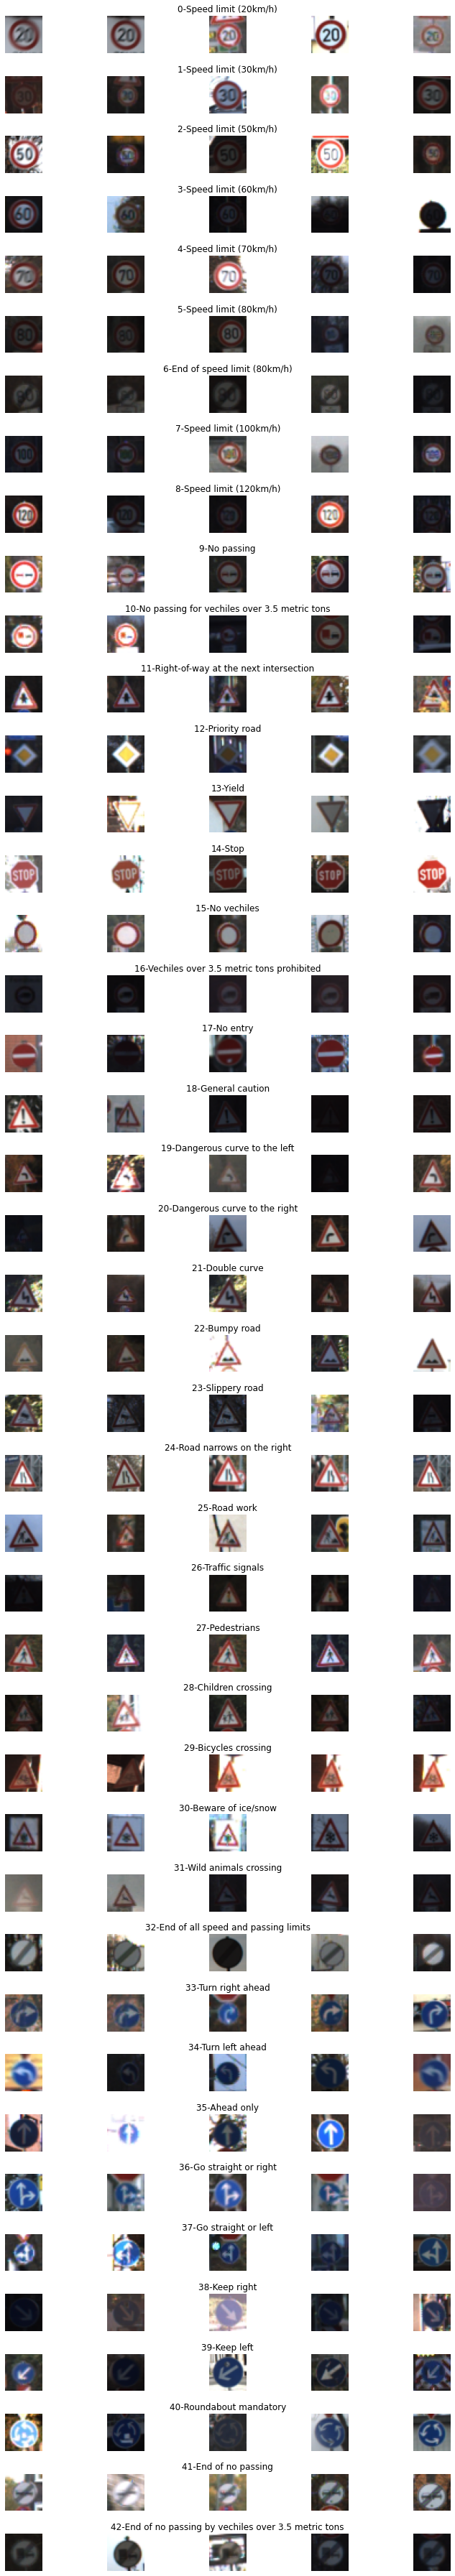

In [93]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(10, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-'+row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


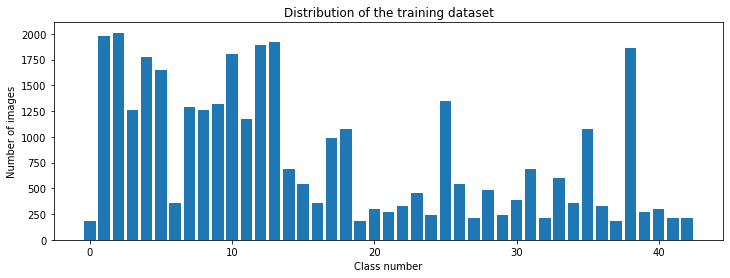

In [94]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [95]:
np.std(num_of_samples)

619.4201837045108

In [96]:
print(np.max(num_of_samples), np.min(num_of_samples))

2010 180


## preprocessing

(32, 32, 3)
31


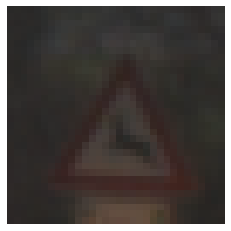

In [97]:
plt.imshow(X_train[222])
plt.axis('off')
print(X_train[222].shape)
print(y_train[222])

### convert to gray

(32, 32)


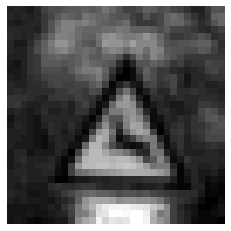

In [98]:
def grayscale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

img = grayscale(X_train[222])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

### histogram equalization

(32, 32)


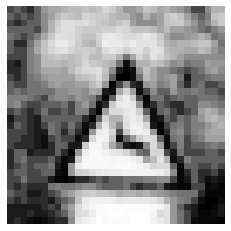

In [99]:
def equalize(img):
    # equalizeHist funciont only accept gray images
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

img = equalize(img)
print(img.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [100]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train=np.array(list(map(preprocessing, X_train)))
X_val=np.array(list(map(preprocessing, X_val)))
X_test=np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


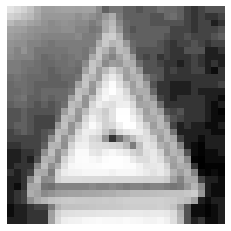

In [101]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)
plt.show()

In [102]:
X_train=X_train.reshape(34799, 32, 32, 1)
X_test=X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val=X_val.reshape(X_val.shape[0], 32, 32, 1)

In [103]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [104]:
y_train=to_categorical(y_train, 43)
y_test=to_categorical(y_test, 43)
y_val=to_categorical(y_val, 43)

In [127]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [128]:
model = modified_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [129]:
history=model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=True)

Epoch 1/15
87/87 [==============================] - 389s 4s/step - loss: 2.7736 - accuracy: 0.2601 - val_loss: 0.9555 - val_accuracy: 0.7608
Epoch 2/15
87/87 [==============================] - 474s 5s/step - loss: 0.8033 - accuracy: 0.7550 - val_loss: 0.2986 - val_accuracy: 0.9163
Epoch 3/15
87/87 [==============================] - 451s 5s/step - loss: 0.4212 - accuracy: 0.8690 - val_loss: 0.1863 - val_accuracy: 0.9469
Epoch 4/15
87/87 [==============================] - 464s 5s/step - loss: 0.3017 - accuracy: 0.9066 - val_loss: 0.1462 - val_accuracy: 0.9556
Epoch 5/15
87/87 [==============================] - 464s 5s/step - loss: 0.2298 - accuracy: 0.9280 - val_loss: 0.1216 - val_accuracy: 0.9633
Epoch 6/15
87/87 [==============================] - 487s 6s/step - loss: 0.1939 - accuracy: 0.9387 - val_loss: 0.0942 - val_accuracy: 0.9753
Epoch 7/15
87/87 [==============================] - 469s 5s/step - loss: 0.1658 - accuracy: 0.9479 - val_loss: 0.0886 - val_accuracy: 0.9735
Epoch 8/15
87

In [130]:
score=model.evaluate(X_test, y_test, verbose=0)
print('accuracy = ', round(score[1]*100, 3),'%', '\nloss = ', round(score[0], 3))

accuracy =  96.635 % 
loss =  0.112


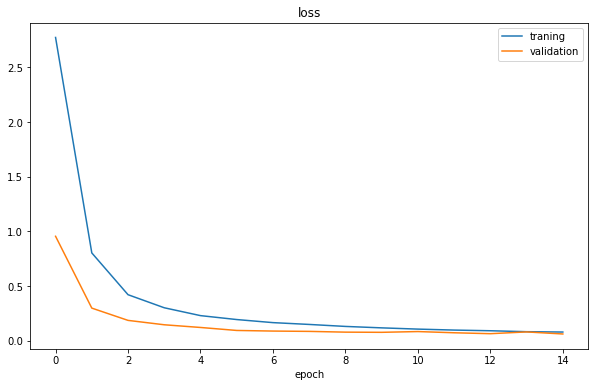

In [131]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

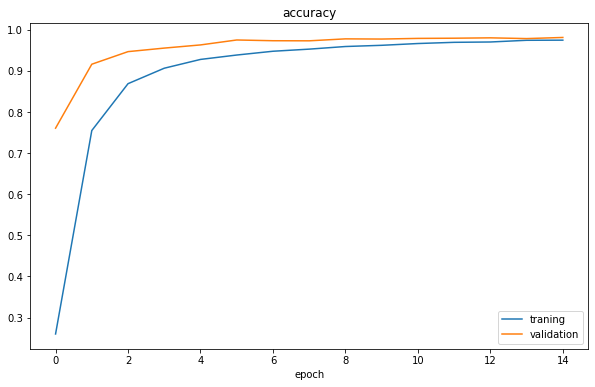

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [133]:
model.save('models')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


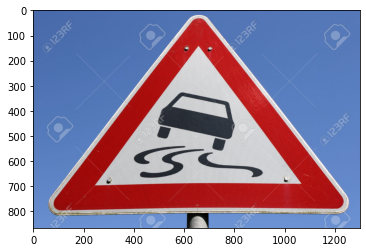

In [172]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url2 = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url3 = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url4 = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url5 = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url3, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

(32, 32)


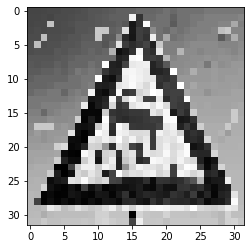

In [173]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [174]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [175]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img))))

1/1 [==============================] - 0s 34ms/step
predicted sign: 23


In [176]:
data.loc[23]['SignName']

'Slippery road'

In [179]:
model2 = keras.models.load_model('model1')

In [181]:
np.argmax(model2.predict(img, verbose=0))

23